<a href="https://colab.research.google.com/github/ManelSoengas/NLP_Curs/blob/main/Utilitzant_Transformers_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Datasets**

---
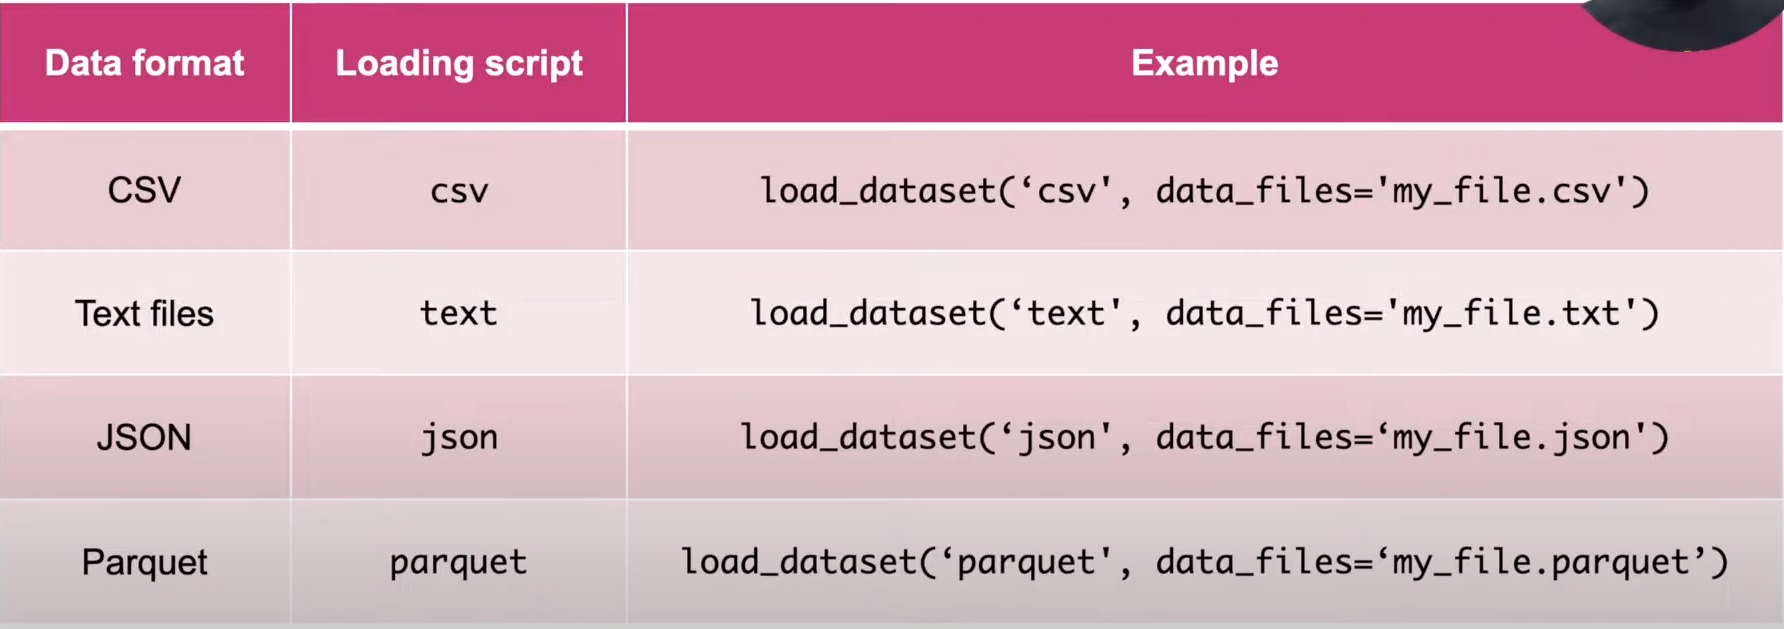

Sovint ens trobarem treballant amb dades que s'emmagatzemen al vostre ordinador portàtil o en un servidor remot. A continuació mostrarem com els conjunts de dades es poden utilitzar per carregar conjunts de dades que no estan disponibles al Hugging Face Hub.


1. **Carregant un dataset en local**

In [ ]:
!wget https://github.com/crux82/squad-it/raw/master/SQuAD_it-train.json.gz
!wget https://github.com/crux82/squad-it/raw/master/SQuAD_it-test.json.gz

In [ ]:
!gzip -dkv SQuAD_it-*.json.gz

In [ ]:
!pip install datasets

from datasets import load_dataset

squad_it_dataset = load_dataset("json", data_files="SQuAD_it-train.json", field="data")

In [ ]:
squad_it_dataset

In [ ]:
squad_it_dataset["train"][0]

In [ ]:
data_files = {"train": "SQuAD_it-train.json", "test": "SQuAD_it-test.json"}
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")
squad_it_dataset

Els scripts de càrrega de Datasets realment admeten la descompressió automàtica dels fitxers d'entrada, de manera que podríem haver saltat l'ús de gzip apuntant l'argument data_files directament als fitxers comprimits:

In [ ]:
data_files = {"train": "SQuAD_it-train.json.gz", "test": "SQuAD_it-test.json.gz"}
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")

2. **Càrrega remota de Datasets**

In [ ]:
url = "https://github.com/crux82/squad-it/raw/master/"
data_files = {
    "train": url + "SQuAD_it-train.json.gz",
    "test": url + "SQuAD_it-test.json.gz",
}
squad_it_dataset = load_dataset("json", data_files=data_files, field="data")

# **Hora de tallar i manipular les dades**

---
La majoria de les vegades, les dades amb les quals treballem no estaran perfectament preparades per als models d'entrenament. A continuació s'explora les diferents funcions que Datasets ofereix per netejar els conjunts de dades.
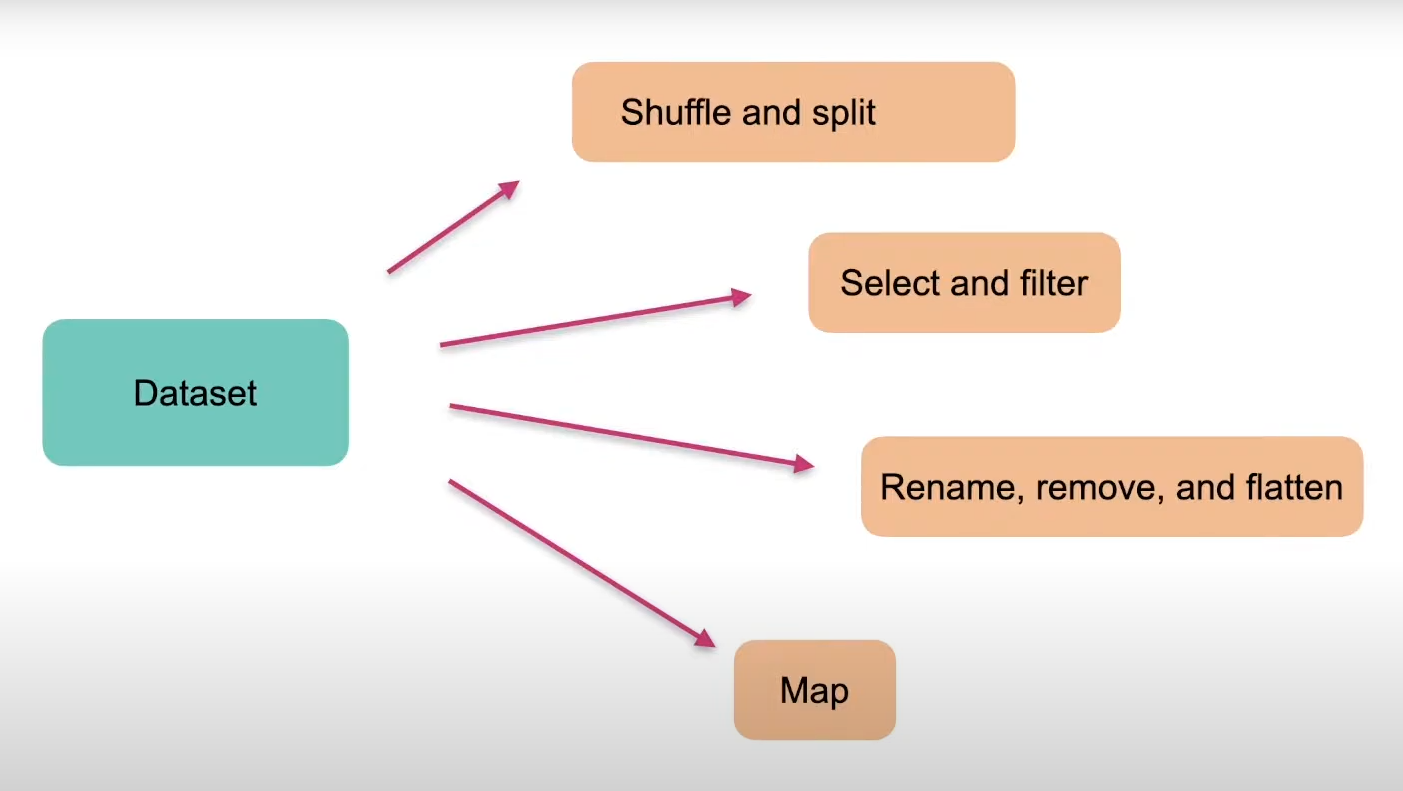

In [ ]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
!unzip drugsCom_raw.zip

In [ ]:
from datasets import load_dataset

data_files = {"train": "drugsComTrain_raw.tsv", "test": "drugsComTest_raw.tsv"}
# \t is the tab character in Python
drug_dataset = load_dataset("csv", data_files=data_files, delimiter="\t")

1. Accedeix al split train del dataset drug_dataset.

1. Barreja (shuffle) aleatòriament l’ordre de les dades.

1. Selecciona les primeres 1000 instàncies del dataset barrejat.

1. Desa aquest subconjunt a la variable drug_sample.

1. El paràmetre seed estableix la "llavor" del generador aleatori. És útil per garantir la reproductibilitat.
Si s'utilitza seed=42 (o qualsevol valor fix), la barreja sempre serà la mateixa cada vegada que s'executi el codi.


In [ ]:
drug_sample = drug_dataset["train"].shuffle(seed=42).select(range(1000))
# Peek at the first few examples
drug_sample[:3]

D'aquesta mostra ja podem veure algunes peculiaritats del conjunt de dades:

1. La columna Sense nom: 0 sembla sospitosament com un identificador anònim per a cada pacient.
1. La columna de condició inclou una barreja d'etiquetes en majúscules i minúscules.
1. Les ressenyes tenen una longitud variable i contenen una combinació de separadors de línies de Python (\r\n) així com codis de caràcters HTML com &#039;.

In [13]:
# Objectiu:  assegurar que no hi ha valors duplicats en una determinada columna
# del dataset per a cada split (com train, test, etc.).

for split in drug_dataset.keys():
    assert len(drug_dataset[split]) == len(drug_dataset[split].unique("Unnamed: 0"))

In [ ]:
# Rename la columna Unnamed
drug_dataset = drug_dataset.rename_column(
    original_column_name="Unnamed: 0", new_column_name="patient_id"
)
drug_dataset

In [ ]:
#  Eliminar totes les files (exemples) del dataset drug_dataset on el camp "condition" és None.
drug_dataset = drug_dataset.filter(lambda x: x["condition"] is not None)


In [ ]:
# Aplicar la funció lowercase_condition a tot el dataset

drug_dataset = drug_dataset.map(lowercase_condition)
# Check that lowercasing worked
drug_dataset["train"]["condition"][:3]

**Crear noves columnes**

Aquest codi afegeix una nova columna al dataset anomenada review_length, que conté el nombre de paraules de cada valor a la columna review

In [18]:
def compute_review_length(example):
    return {"review_length": len(example["review"].split())}

In [ ]:
drug_dataset = drug_dataset.map(compute_review_length)
# Inspect the first training example
drug_dataset["train"][0]

In [ ]:
# Ordenar la nova columna afegida

drug_dataset["train"].sort("review_length")[:3]

In [ ]:
# Aquest codi serveix per filtrar el dataset i eliminar les ressenyes curtes

drug_dataset = drug_dataset.filter(lambda x: x["review_length"] > 30)
print(drug_dataset.num_rows)


In [ ]:
# Tractar la presència de codis de caràcters HTML a les nostres ressenyes

import html


drug_dataset = drug_dataset.map(lambda x: {"review": html.unescape(x["review"])})

**El mètode MAP**

El Dataset.map()mètode pren un batchedargument que, si s'estableix a True, fa que enviï un lot d'exemples a la funció de mapa alhora.

In [ ]:
new_drug_dataset = drug_dataset.map(
    lambda x: {"review": [html.unescape(o) for o in x["review"]]}, batched=True
)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["review"], truncation=True)

In [ ]:
%time tokenized_dataset = drug_dataset.map(tokenize_function, batched=True)

# **Dades + PANDA**

---
Per habilitar la conversió entre diverses biblioteques de tercers, Datasets ofereix una Dataset.set_format()funció. Aquesta funció només canvia el format de sortida del conjunt de dades, de manera que es pot canviar fàcilment a un altre format sense afectar el format de dades subjacent.


In [27]:
drug_dataset.set_format("pandas")

In [ ]:
drug_dataset["train"][:3]

In [29]:
train_df = drug_dataset["train"][:]

In [ ]:
frequencies = (
    train_df["condition"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"index": "condition", "condition": "frequency"})
)
frequencies.head()

In [ ]:
from datasets import Dataset

freq_dataset = Dataset.from_pandas(frequencies)
freq_dataset

In [32]:
drug_dataset.reset_format()

# **Creació d'un conjunt de validació**

---
Tot i que disposem d'un conjunt de proves que podríem utilitzar per a l'avaluació, és una bona pràctica deixar el conjunt de proves sense tocar i crear un conjunt de validació independent durant el desenvolupament. Un cop estigueu satisfet amb el rendiment dels vostres models al conjunt de validació, podeu fer una comprovació final de cor del conjunt de proves. Aquest procés ajuda a mitigar el risc que s'ajusti en excés al conjunt de proves i implementi un model que falla a les dades del món real.


In [ ]:
drug_dataset_clean = drug_dataset["train"].train_test_split(train_size=0.8, seed=42)
# Rename the default "test" split to "validation"
drug_dataset_clean["validation"] = drug_dataset_clean.pop("test")
# Add the "test" set to our `DatasetDict`
drug_dataset_clean["test"] = drug_dataset["test"]
drug_dataset_clean